In [ ]:
import torch
import cv2
import torch.utils.data as data
from torchvision import transforms
import os
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
import math
from tqdm import tqdm
import numpy as np

## Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/causalidade/dataset.zip'

Output streaming troncato alle ultime 5000 righe.
  inflating: yes/Tr-gl_0929.jpg      
  inflating: yes/Tr-gl_0930.jpg      
  inflating: yes/Tr-gl_0931.jpg      
  inflating: yes/Tr-gl_0932.jpg      
  inflating: yes/Tr-gl_0933.jpg      
  inflating: yes/Tr-gl_0934.jpg      
  inflating: yes/Tr-gl_0935.jpg      
  inflating: yes/Tr-gl_0936.jpg      
  inflating: yes/Tr-gl_0937.jpg      
  inflating: yes/Tr-gl_0938.jpg      
  inflating: yes/Tr-gl_0939.jpg      
  inflating: yes/Tr-gl_0940.jpg      
  inflating: yes/Tr-gl_0941.jpg      
  inflating: yes/Tr-gl_0942.jpg      
  inflating: yes/Tr-gl_0943.jpg      
  inflating: yes/Tr-gl_0944.jpg      
  inflating: yes/Tr-gl_0945.jpg      
  inflating: yes/Tr-gl_0946.jpg      
  inflating: yes/Tr-gl_0947.jpg      
  inflating: yes/Tr-gl_0948.jpg      
  inflating: yes/Tr-gl_0949.jpg      
  inflating: yes/Tr-gl_0950.jpg      
  inflating: yes/Tr-gl_0951.jpg      
  inflating: yes/Tr-gl_0952.jpg      
  inflating: yes/Tr-gl_0953.jpg      


## Pre-Processing

## Dataloader

In [ ]:
class ImageDataset(data.TensorDataset):
    def __init__(self, img_list, labels_list, dir, test = False, num_classes = 2):
        self.img_list = img_list
        self.labels = labels_list
        self.dir = dir
        self.test = test
        self.num_classes = num_classes

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        get tensor type preprocessed Image
        '''
        convert_tensor = transforms.ToTensor()
        img = cv2.imread(os.path.join(self.dir, self.img_list[index]), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(256,256))
        img = convert_tensor(img)
        if self.num_classes == 2:
          ret_labels = torch.Tensor([self.labels[index]])
        else:
          ret_labels = torch.Tensor([x==self.labels[index] for x in range(self.num_classes)])
        return img, ret_labels

In [ ]:
def CreateBinaryDataset(base_dir, yes_dirs, no_dirs, dataset_dir, val = 0.15):
    train_labels = []
    train_images = []
    val_labels = []
    val_images = []
    for f in os.listdir(base_dir):
        if f in yes_dirs:
            for img in os.listdir(os.path.join(base_dir, f)):
                num = random.random()
                img = os.path.join(f, img)
                if(num < val):
                    val_images.append(img)
                    val_labels.append(1)
                else:
                    train_images.append(img)
                    train_labels.append(1)

        if f in no_dirs:
            for img in os.listdir(os.path.join(base_dir, f)):
                img = os.path.join(f, img)
                num = random.random()
                if(num < val):
                    val_images.append(img)
                    val_labels.append(0)
                else:
                    train_images.append(img)
                    train_labels.append(0)

    train_dataset = ImageDataset(train_images, train_labels, dataset_dir)
    val_dataset = ImageDataset(val_images, val_labels, dataset_dir)

    return train_dataset, val_dataset


In [ ]:

def CreateClassDataset(base_dir, dataset_dir, classes = None, val = 0.15):
  train_labels = []
  train_images = []
  val_labels = []
  val_images = []

  i = 0
  for f in os.listdir(base_dir):
      if classes is not None and f in classes:
        for img in os.listdir(os.path.join(base_dir, f)):
            num = random.random()
            img = os.path.join(f, img)
            if(num < val):
                val_images.append(img)
                val_labels.append(i)
            else:
                train_images.append(img)
                train_labels.append(i)
        i += 1
        
  train_dataset = ImageDataset(train_images, train_labels, dataset_dir, num_classes = len(classes))
  val_dataset = ImageDataset(val_images, val_labels, dataset_dir, num_classes = len(classes))

  return train_dataset, val_dataset

In [ ]:
base_dir = '/content'

In [ ]:
## CREATES BINARY DATASET

train, val = CreateBinaryDataset(base_dir, ['yes'], ['no', 'pituary', 'meningioma'], base_dir)
train_dataloader = data.DataLoader(train, batch_size = 8, shuffle=True, num_workers=0, drop_last = False)
val_dataloader = data.DataLoader(val, batch_size = 8, shuffle=True, num_workers=0, drop_last = False)

In [ ]:
train, val = CreateClassDataset(base_dir, base_dir, classes = ['yes', 'no', 'meningioma', 'pituary'])
train_dataloader = data.DataLoader(train, batch_size = 8, shuffle=True, num_workers=0, drop_last = False)
val_dataloader = data.DataLoader(val, batch_size = 1, shuffle=True, num_workers=0, drop_last = False)

tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


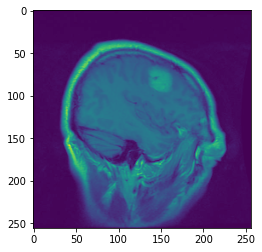

NameError: ignored

In [ ]:
for img, label in train_dataloader:
        print(label)
        plt.imshow(img[0][0])
        plt.show()
        asd

## Models

#### Base Blocks

In [ ]:
def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun

In [ ]:
class Dense(nn.Module):
    def __init__(self, in_channels, out_channels, before = None, after = False, bias=True, device=None, dtype=None):
        super(Dense, self).__init__()
        self.dense = nn.Linear(in_channels, out_channels, bias = bias)
        self.dense.apply(weights_init('xavier'))

        if after=='BN':
            self.after = nn.BatchNorm2d(out_channels)
        elif after=='Tanh':
            self.after = torch.tanh
        elif after=='sigmoid':
            self.after = torch.sigmoid
        elif after == 'softmax':
            self.after = nn.Softmax(dim = 1)

        if before=='ReLU':
            self.before = nn.ReLU(inplace=False)
        elif before=='LReLU':
            self.before = nn.LeakyReLU(negative_slope=0.2, inplace=True)
          
    def forward(self, x):
      if hasattr(self, 'before'):
          x = self.before(x)
      x = self.dense(x)
      if hasattr(self, 'after'):
          x = self.after(x)
      return x

In [ ]:
class Cvi(nn.Module):
    def __init__(self, in_channels, out_channels, before=None, after=False, kernel_size=4, stride=2,
                 padding=1, dilation=1, groups=1, bias=True):
        super(Cvi, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.conv.apply(weights_init('orthogonal'))

        if after=='BN':
            self.after = nn.BatchNorm2d(out_channels)
        elif after=='Tanh':
            self.after = torch.tanh
        elif after=='sigmoid':
            self.after = nn.Sigmoid()
        elif after == 'softmax':
            self.after = nn.Softmax(dim = 1)
        elif(after == 'maxPooling'):
            self.after = nn.MaxPool2d(kernel_size = 2)
        elif(after == 'flatten'):
            self.after = nn.Flatten

        if before=='ReLU':
            self.before = nn.ReLU(inplace=False)
        elif before=='LReLU':
            self.before = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):

        if hasattr(self, 'before'):
            x = self.before(x)

        x = self.conv(x)

        if hasattr(self, 'after'):
            x = self.after(x)

        return x

#### Test Model for Binary

In [ ]:
class TestModel(nn.Module):
    def __init__(self):
      super(TestModel,self).__init__()

      self.c1 = Cvi(1, 16, before = None, after='BN')
      self.c2 = Cvi(16, 32, before = 'ReLu', after='BN')
      self.c3 = Cvi(32, 64, before = 'ReLu', after='BN')
      self.c4 = Cvi(64, 128, before = 'ReLu', after='BN')
      self.l1 = Dense(32768, 512,after = 'sigmoid')
      self.l2 = Dense(512, 1,after = 'sigmoid')


    def forward(self, input):
        x1 = self.c1(input)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)
        x5 = x4.view(x4.size(0),-1)
        x6 = self.l1(x5)
        x7 = self.l2(x6)

        return x7

model = TestModel()

#### Test Model for Classes

In [ ]:
class ClassTestModel(nn.Module):
    def __init__(self):
      super(ClassTestModel,self).__init__()

      self.c1 = Cvi(1, 16, before = None, after='BN')
      self.c2 = Cvi(16, 32, before = 'ReLu', after='BN')
      self.c3 = Cvi(32, 64, before = 'ReLu', after='BN')
      self.c4 = Cvi(64, 128, before = 'ReLu', after='BN')
      self.l1 = Dense(32768, 512,after = 'sigmoid')
      self.l2 = Dense(512, 4,after = 'sigmoid')


    def forward(self, input):
        x1 = self.c1(input)
        x2 = self.c2(x1)
        x3 = self.c3(x2)
        x4 = self.c4(x3)
        x5 = x4.view(x4.size(0),-1)
        x6 = self.l1(x5)
        x7 = self.l2(x6)

        return x7

model = ClassTestModel()

## Training

In [ ]:

def fix_model_state_dict(state_dict):
    '''
    remove 'module.' of dataparallel
    '''
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if name.startswith('module.'):
            name = name[7:]
        new_state_dict[name] = v
    return new_state_dict

In [ ]:
## MUDAR

def evaluate(model, dataloader):
  print('Starting Validation')
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  model.eval()
  criterion = nn.CrossEntropyLoss().to(device)
  loss = 0
  loss_l2 = 0
  accs = 0
  i = 0
  right = []
  pred = []
  with torch.no_grad():
      for imgs, labels in tqdm(dataloader):
          #comms = comms.unsqueeze(1)
          imgs = imgs.to(device)
          labels = labels.to(device)
          outs = model(imgs)
          error = criterion(outs, labels.float()).to(device)
          loss += error.detach()
          if labels[0][torch.argmax(outs)] == 1:
            accs += 1
          i += 1
          right.append(np.array(labels[0].cpu()))
          pred.append(np.array(outs[0].cpu()))
  print('LOSS:', loss/i)
  print("ACCURACY:", accs/(i*dataloader.batch_size))
  return pred, right

In [ ]:
model = TestModel()

NameError: ignored

In [ ]:
num_epochs = 25 
VAL_FREQ = 5
SAVE_FREQ = None
load = None
load_dir= None

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


if load != None:
  model_weights = torch.load(load_dir + 'ckpt' +str(load) +'BCE.pth')
  model.load_state_dict(fix_model_state_dict(model_weights))
  

'''optimizer = torch.optim.SGD([{'params': model.parameters()}],
                                  lr=0.0005, momentum=0.9)'''
#optimizer = torch.optim.Adamax([{'params': model.parameters()}], lr=0.0005)
optimizer = torch.optim.Adam([{'params':model.parameters()}], lr = 0.0001)

criterion = nn.CrossEntropyLoss()
#criterion = nn.L1Loss()
#criterion2 = nn.MSELoss()

epoch_loss = 0
num_batches = 0

for i in range(num_epochs):
    epoch_loss = 0
    for imgs, labels in tqdm(train_dataloader):
      optimizer.zero_grad()
      #print(labels)
      num_batches += 1
      model.train()

      imgs = imgs.to(device)
      labels = labels.to(device)
      outs = model(imgs)
      error = criterion(outs, labels.float()).to(device)
      #error2 = criterion2(outs, labels.float()).to(device)
      #ERROR = error + error2
      ERROR = error
      a = list(model.parameters())[1].clone()
      ERROR.backward()
      optimizer.step()
      epoch_loss += ERROR.detach()
      b = list(model.parameters())[1].clone()
      #print(a==b)

    print("Total Epoch Loss:", epoch_loss, "Loss per batch:", epoch_loss/num_batches)
    num_batches = 0
    '''if i%VAL_FREQ == 0:
      evaluate(model, val_dataloader)
    if i%SAVE_FREQ == 0 or i==num_epochs-1:
      if load == None:
        torch.save(model.state_dict(), load_dir + 'ckp.' + str(i) +'.pth')
      else:
        torch.save(model.state_dict(), load_dir + 'ckpt' + str(int(i) + int(load) + 1)+'BCE.pth')'''

print(epoch_loss)

100%|██████████| 1103/1103 [00:21<00:00, 52.39it/s]


Total Epoch Loss: tensor(1109.5438, device='cuda:0') Loss per batch: tensor(1.0059, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.44it/s]


Total Epoch Loss: tensor(965.4889, device='cuda:0') Loss per batch: tensor(0.8753, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.31it/s]


Total Epoch Loss: tensor(911.4034, device='cuda:0') Loss per batch: tensor(0.8263, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.28it/s]


Total Epoch Loss: tensor(876.6932, device='cuda:0') Loss per batch: tensor(0.7948, device='cuda:0')


100%|██████████| 1103/1103 [00:20<00:00, 52.82it/s]


Total Epoch Loss: tensor(858.2712, device='cuda:0') Loss per batch: tensor(0.7781, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.60it/s]


Total Epoch Loss: tensor(848.5459, device='cuda:0') Loss per batch: tensor(0.7693, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.34it/s]


Total Epoch Loss: tensor(842.4835, device='cuda:0') Loss per batch: tensor(0.7638, device='cuda:0')


100%|██████████| 1103/1103 [00:20<00:00, 52.88it/s]


Total Epoch Loss: tensor(839.1362, device='cuda:0') Loss per batch: tensor(0.7608, device='cuda:0')


100%|██████████| 1103/1103 [00:20<00:00, 52.99it/s]


Total Epoch Loss: tensor(839.7505, device='cuda:0') Loss per batch: tensor(0.7613, device='cuda:0')


100%|██████████| 1103/1103 [00:20<00:00, 53.05it/s]


Total Epoch Loss: tensor(838.2909, device='cuda:0') Loss per batch: tensor(0.7600, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.75it/s]


Total Epoch Loss: tensor(835.3812, device='cuda:0') Loss per batch: tensor(0.7574, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.08it/s]


Total Epoch Loss: tensor(834.1718, device='cuda:0') Loss per batch: tensor(0.7563, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.24it/s]


Total Epoch Loss: tensor(832.7855, device='cuda:0') Loss per batch: tensor(0.7550, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.60it/s]


Total Epoch Loss: tensor(832.0990, device='cuda:0') Loss per batch: tensor(0.7544, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.26it/s]


Total Epoch Loss: tensor(832.0185, device='cuda:0') Loss per batch: tensor(0.7543, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.34it/s]


Total Epoch Loss: tensor(839.4835, device='cuda:0') Loss per batch: tensor(0.7611, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.36it/s]


Total Epoch Loss: tensor(831.7691, device='cuda:0') Loss per batch: tensor(0.7541, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 50.53it/s]


Total Epoch Loss: tensor(830.7519, device='cuda:0') Loss per batch: tensor(0.7532, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.17it/s]


Total Epoch Loss: tensor(830.5033, device='cuda:0') Loss per batch: tensor(0.7529, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.53it/s]


Total Epoch Loss: tensor(830.1261, device='cuda:0') Loss per batch: tensor(0.7526, device='cuda:0')


100%|██████████| 1103/1103 [00:20<00:00, 52.84it/s]


Total Epoch Loss: tensor(829.8547, device='cuda:0') Loss per batch: tensor(0.7524, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.57it/s]


Total Epoch Loss: tensor(832.2065, device='cuda:0') Loss per batch: tensor(0.7545, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 50.32it/s]


Total Epoch Loss: tensor(834.9238, device='cuda:0') Loss per batch: tensor(0.7570, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 51.59it/s]


Total Epoch Loss: tensor(830.0484, device='cuda:0') Loss per batch: tensor(0.7525, device='cuda:0')


100%|██████████| 1103/1103 [00:21<00:00, 52.52it/s]

Total Epoch Loss: tensor(829.5575, device='cuda:0') Loss per batch: tensor(0.7521, device='cuda:0')
tensor(829.5575, device='cuda:0')


## Evaluation

In [ ]:
preds, rights = evaluate(model, val_dataloader)

Starting Validation


  1%|▏         | 22/1516 [00:00<00:07, 211.95it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

  3%|▎         | 44/1516 [00:00<00:06, 212.32it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


  4%|▍         | 66/1516 [00:00<00:06, 209.73it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

  6%|▌         | 87/1516 [00:00<00:06, 207.83it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


  7%|▋         | 108/1516 [00:00<00:06, 205.07it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

  9%|▊         | 129/1516 [00:00<00:06, 205.97it/s]


torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


 10%|█         | 152/1516 [00:00<00:06, 211.37it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 11%|█▏        | 174/1516 [00:00<00:06, 211.34it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


 13%|█▎        | 196/1516 [00:00<00:06, 213.13it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 14%|█▍        | 219/1516 [00:01<00:06, 214.86it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])


 16%|█▌        | 241/1516 [00:01<00:06, 209.98it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 19%|█▉        | 285/1516 [00:01<00:05, 210.58it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 22%|██▏       | 328/1516 [00:01<00:05, 207.41it/s]


torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size(

 25%|██▍       | 373/1516 [00:01<00:05, 216.01it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 28%|██▊       | 418/1516 [00:01<00:05, 219.49it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 31%|███       | 463/1516 [00:02<00:04, 220.40it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 34%|███▍      | 512/1516 [00:02<00:04, 228.96it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 37%|███▋      | 558/1516 [00:02<00:04, 219.28it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 40%|███▉      | 602/1516 [00:02<00:04, 217.42it/s]


torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size(

 43%|████▎     | 647/1516 [00:03<00:03, 218.06it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 46%|████▌     | 692/1516 [00:03<00:03, 218.28it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 49%|████▊     | 738/1516 [00:03<00:03, 217.55it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 52%|█████▏    | 782/1516 [00:03<00:03, 212.71it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 54%|█████▍    | 826/1516 [00:03<00:03, 212.43it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 58%|█████▊    | 872/1516 [00:04<00:02, 219.17it/s]


torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size(

 61%|██████    | 918/1516 [00:04<00:02, 218.90it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 63%|██████▎   | 962/1516 [00:04<00:02, 212.12it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 66%|██████▋   | 1007/1516 [00:04<00:02, 215.03it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 69%|██████▉   | 1052/1516 [00:04<00:02, 215.13it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 72%|███████▏  | 1097/1516 [00:05<00:01, 217.25it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 75%|███████▌  | 1142/1516 [00:05<00:01, 219.06it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 78%|███████▊  | 1188/1516 [00:05<00:01, 220.99it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 81%|████████▏ | 1234/1516 [00:05<00:01, 219.59it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 84%|████████▍ | 1279/1516 [00:05<00:01, 216.31it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 87%|████████▋ | 1323/1516 [00:06<00:00, 216.18it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 90%|█████████ | 1369/1516 [00:06<00:00, 220.10it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 93%|█████████▎| 1416/1516 [00:06<00:00, 222.22it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 96%|█████████▋| 1462/1516 [00:06<00:00, 220.86it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

 99%|█████████▉| 1507/1516 [00:07<00:00, 214.18it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

100%|██████████| 1516/1516 [00:07<00:00, 215.15it/s]

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
LOSS: tensor(0.8868, device='cuda:0')
ACCURACY: 0.8555408970976254


In [ ]:
for i in range(len(preds)):
  l = [0,0,0,0]
  l[np.argmax(preds[i])] = 1
  preds[i] = np.array(l)

In [ ]:
from sklearn.metrics import recall_score


recall_score(rights, preds, average=None)

array([0.85526316, 0.68313953, 0.93467337, 0.94339623])

In [ ]:
from sklearn.metrics import precision_score

precision_score(rights, preds, average=None)

array([0.81081081, 0.75562701, 0.91400491, 0.94637224])

In [ ]:
bin_preds = []
bin_rights = []

for i in range(len(preds)):
  bin_preds.append(np.argmax(preds[i]))
  bin_rights.append(np.argmax(rights[i]))

bin_preds = np.array(bin_preds)
bin_rights = np.array(bin_rights)

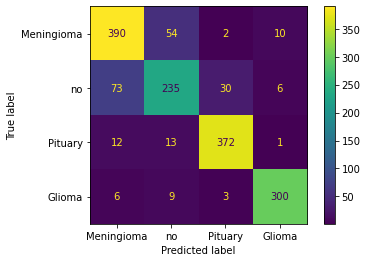

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(bin_rights, bin_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Meningioma', 'no', 'Pituary', 'Glioma'])
disp.plot()

In [ ]:
print(rights)

[[tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(0.), tensor(0.), tensor(0.), tensor(1.)], [tensor(1.), tensor(0.), tensor(0.), tensor(0.)], [tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(0.), tensor(0.), tensor(0.), tensor(1.)], [tensor(0.), tensor(0.), tensor(0.), tensor(1.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(1.), tensor(0.), tensor(0.), tensor(0.)], [tensor(0.), tensor(0.), tensor(1.), tensor(0.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(1.), tensor(0.), tensor(0.), tensor(0.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(0.), tensor(0.), tensor(0.), tensor(1.)], [tensor(0.), tensor(1.), tensor(0.), tensor(0.)], [tensor(1.), tensor(0.), tensor(0.), tensor(0.)],

In [ ]:
print(preds)

[[tensor(8.4883e-07), tensor(1.1069e-07), tensor(0.9988), tensor(0.0050)], [tensor(0.0004), tensor(2.0074e-06), tensor(2.1475e-08), tensor(1.0000)], [tensor(1.0000), tensor(1.3874e-06), tensor(8.2387e-07), tensor(3.5902e-07)], [tensor(4.2900e-09), tensor(0.0002), tensor(0.9990), tensor(0.0003)], [tensor(0.0003), tensor(7.7449e-07), tensor(0.9998), tensor(9.8380e-06)], [tensor(4.3224e-06), tensor(1.0000), tensor(9.5056e-06), tensor(9.8540e-07)], [tensor(0.2158), tensor(0.0002), tensor(0.0015), tensor(0.0007)], [tensor(1.3578e-06), tensor(2.9179e-05), tensor(0.9997), tensor(2.2372e-05)], [tensor(0.0002), tensor(3.4749e-05), tensor(1.7377e-05), tensor(0.9891)], [tensor(0.0014), tensor(0.0018), tensor(3.3892e-09), tensor(0.9993)], [tensor(0.8381), tensor(0.2268), tensor(7.3125e-06), tensor(3.2815e-08)], [tensor(7.7503e-09), tensor(5.6131e-05), tensor(1.0000), tensor(3.4940e-05)], [tensor(0.0990), tensor(0.9636), tensor(0.0001), tensor(7.4942e-09)], [tensor(8.0303e-09), tensor(0.0045), tens